In [1]:
import os
import sys

In [2]:
sys.path.append('..')

In [3]:
from helpers import *

In [4]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
tf_gpus = [x for x in device_lib.list_local_devices() if x.device_type == 'GPU']


In [5]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [6]:
print(tf.__version__)
print(tf_gpus)

1.12.0
[name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6703746908
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15181122868549583698
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [7]:
from scipy.stats import pearsonr

In [8]:
df = msframe('AAPL', 'MSFT', _filter=lambda x: 'adj_close' in x)

In [9]:
pdf = df.pct_change().dropna()

In [10]:
pdf.head()

,AAPL_adj_close,MSFT_adj_close
1998-01-03,-0.007577,-0.001904
1998-01-04,-0.007635,-0.001908
1998-01-05,-0.007694,-0.001911
1998-01-06,0.192701,0.005745
1998-01-07,-0.075992,-0.011967


In [11]:
w_size = 30
window_df = pd.concat([left_windows(pdf[c],w_size) for c in pdf.columns], axis=1)

In [12]:
window_df.shape

(7753, 60)

In [13]:
y = pdf.AAPL_adj_close.loc[window_df.index]

In [14]:
cutoff = datetime.datetime(2009,1,1)

In [15]:
train_x, train_y = window_df[:cutoff], y[:cutoff]
test_x, test_y = window_df[cutoff:], y[cutoff:]

In [16]:
inp = keras.layers.Input(shape=(60,1))
conv = keras.layers.Conv1D(filters=2, kernel_size=2)(inp)
pool = keras.layers.MaxPool1D(pool_size=2)(conv)
flat = keras.layers.Flatten()(pool)
dense = keras.layers.Dense(1)(flat)
model = keras.Model(inp, dense)
model.compile(loss='mse', optimizer='adam')

In [17]:
# # https://en.wikipedia.org/wiki/Activation_function
# model = keras.Sequential([
#     keras.layers.Conv1D(filters=5,kernel_size=5,activation="linear",input_shape=(2*w_size,1)),
#     keras.layers.Dense(5,activation="linear",input_dim=5),
#     keras.layers.Dense(1,activation="linear")
# ])

In [18]:
# model.compile(optimizer=tf.train.AdamOptimizer(), 
#               loss='mean_squared_error',
#               metrics=['accuracy'])

In [19]:
J = np.expand_dims(train_x.values,axis=2)

In [20]:
J.shape

(3987, 60, 1)

In [21]:
model.fit(J,train_y.values,epochs=5)

Epoch 1/5


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1d/conv1d/Conv2D}} = Conv2D[T=DT_FLOAT, _class=["loc:@training/Adam/gradients/conv1d/conv1d/Conv2D_grad/Conv2DBackpropFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/gradients/conv1d/conv1d/Conv2D_grad/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer, conv1d/conv1d/ExpandDims_1)]]
	 [[{{node loss/dense_loss/broadcast_weights/assert_broadcastable/AssertGuard/Assert/Switch_2/_73}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_203_l...t/Switch_2", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [44]:
test_loss, test_acc = model.evaluate(test_x.values, test_y.values)
test_loss, test_acc

3767/3767 [==============================] - 0s 47us/step


(0.00017002073006771603, 0.0015927794000530925)

<br></br>
## Plot test data

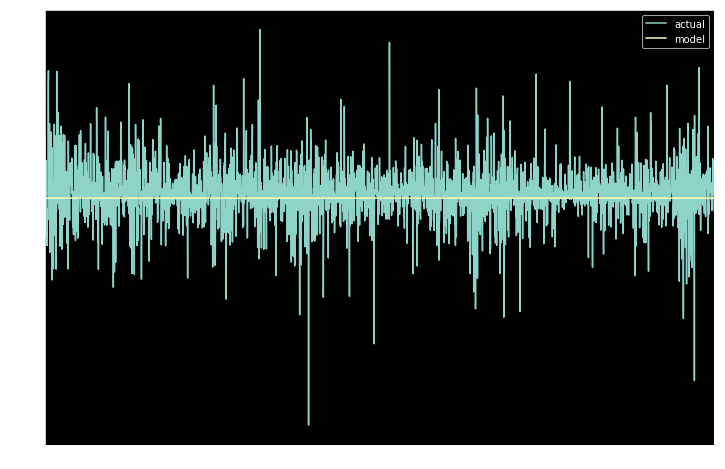

In [45]:
test_yh = np.squeeze(model.predict(test_x))
test_yh = pd.Series(test_yh, index=test_y.index)
compare = pd.concat([test_y.rename('actual'),test_yh.rename('model')],axis=1)
compare.plot(figsize=(12,8))

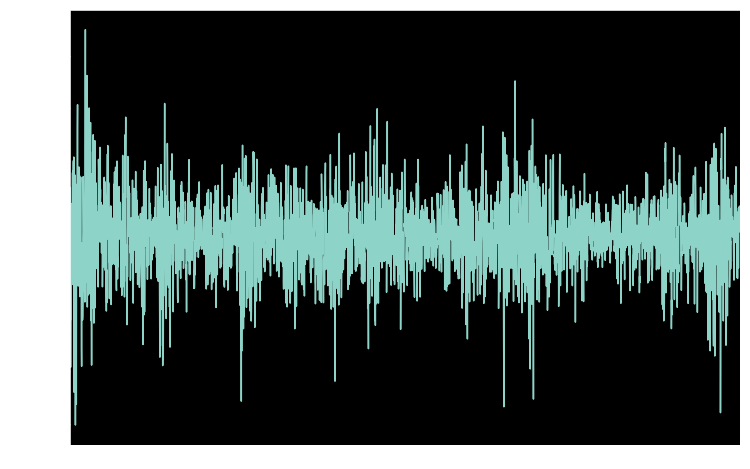

In [46]:
test_yh.plot(figsize=(12,8))

In [47]:
print("Correlation: {}".format(pearsonr(test_y, test_yh)))

Correlation: (0.008252233196338757, 0.6126259236141767)


<br></br>
### Plot train data

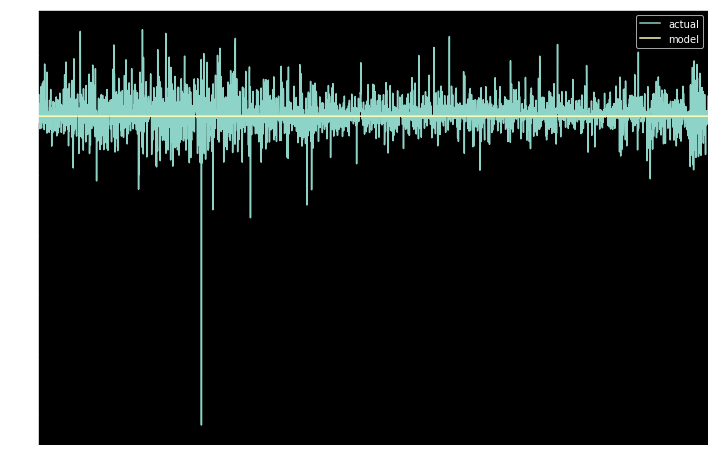

In [48]:
train_yh = np.squeeze(model.predict(train_x))
train_yh = pd.Series(train_yh, index=train_y.index)
compare = pd.concat([train_y.rename('actual'),train_yh.rename('model')],axis=1)
compare.plot(figsize=(12,8))

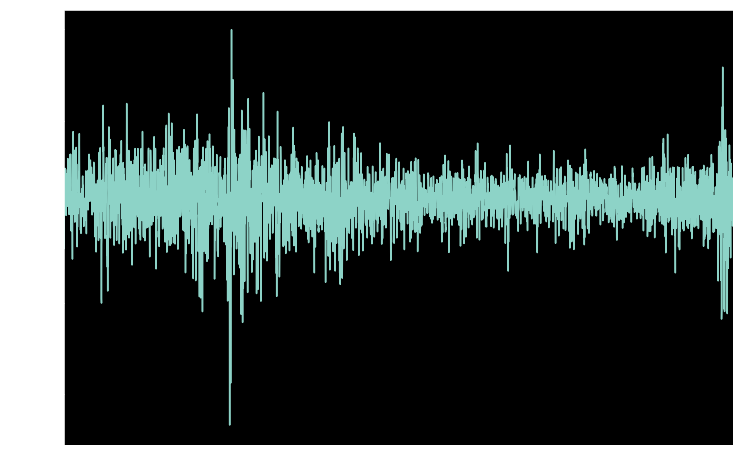

In [49]:
train_yh.plot(figsize=(12,8))